## Import

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import random
import pandas as pd
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt

import torch
# import torch.nn as nn

import torchvision
import torchvision.models as models
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
# from torchvision.models.detection.rpn import AnchorGenerator
# from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from tqdm.auto import tqdm

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
device

device(type='mps')

In [4]:
working_dir = 'synthesis-car-od'
dir_len = len(working_dir)

path = os.getcwd().replace('\\', '/')
index = path.find(working_dir)
working_dir = path[:index + dir_len + 1]
working_dir

'/Users/a16/Desktop/JJ/self_study/projects/synthesis-car-od/'

In [5]:
SUBMIT_NAME = 'torchvision_faster_rcnn'
DATA_PATH = os.path.join(working_dir, 'data/')

## Hyperparameter Setting

In [6]:
CFG = {
    'NUM_CLASS': 34,
    'IMG_SIZE': 1024,
    'EPOCHS': 20,
    'LR': 3e-4,
    'BATCH_SIZE': 8,
    'SEED': 41,
    # 'MEAN': [0.4370, 0.4336, 0.4148], # RGB
    'MEAN': [0.4325, 0.4325, 0.4325], # Grayscale
    # 'STD': [0.2531, 0.2283, 0.1971], # RGB
    'STD': [0.2300, 0.2300, 0.2300], # Grayscale
}

## Fixed Random-Seed

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Visualization

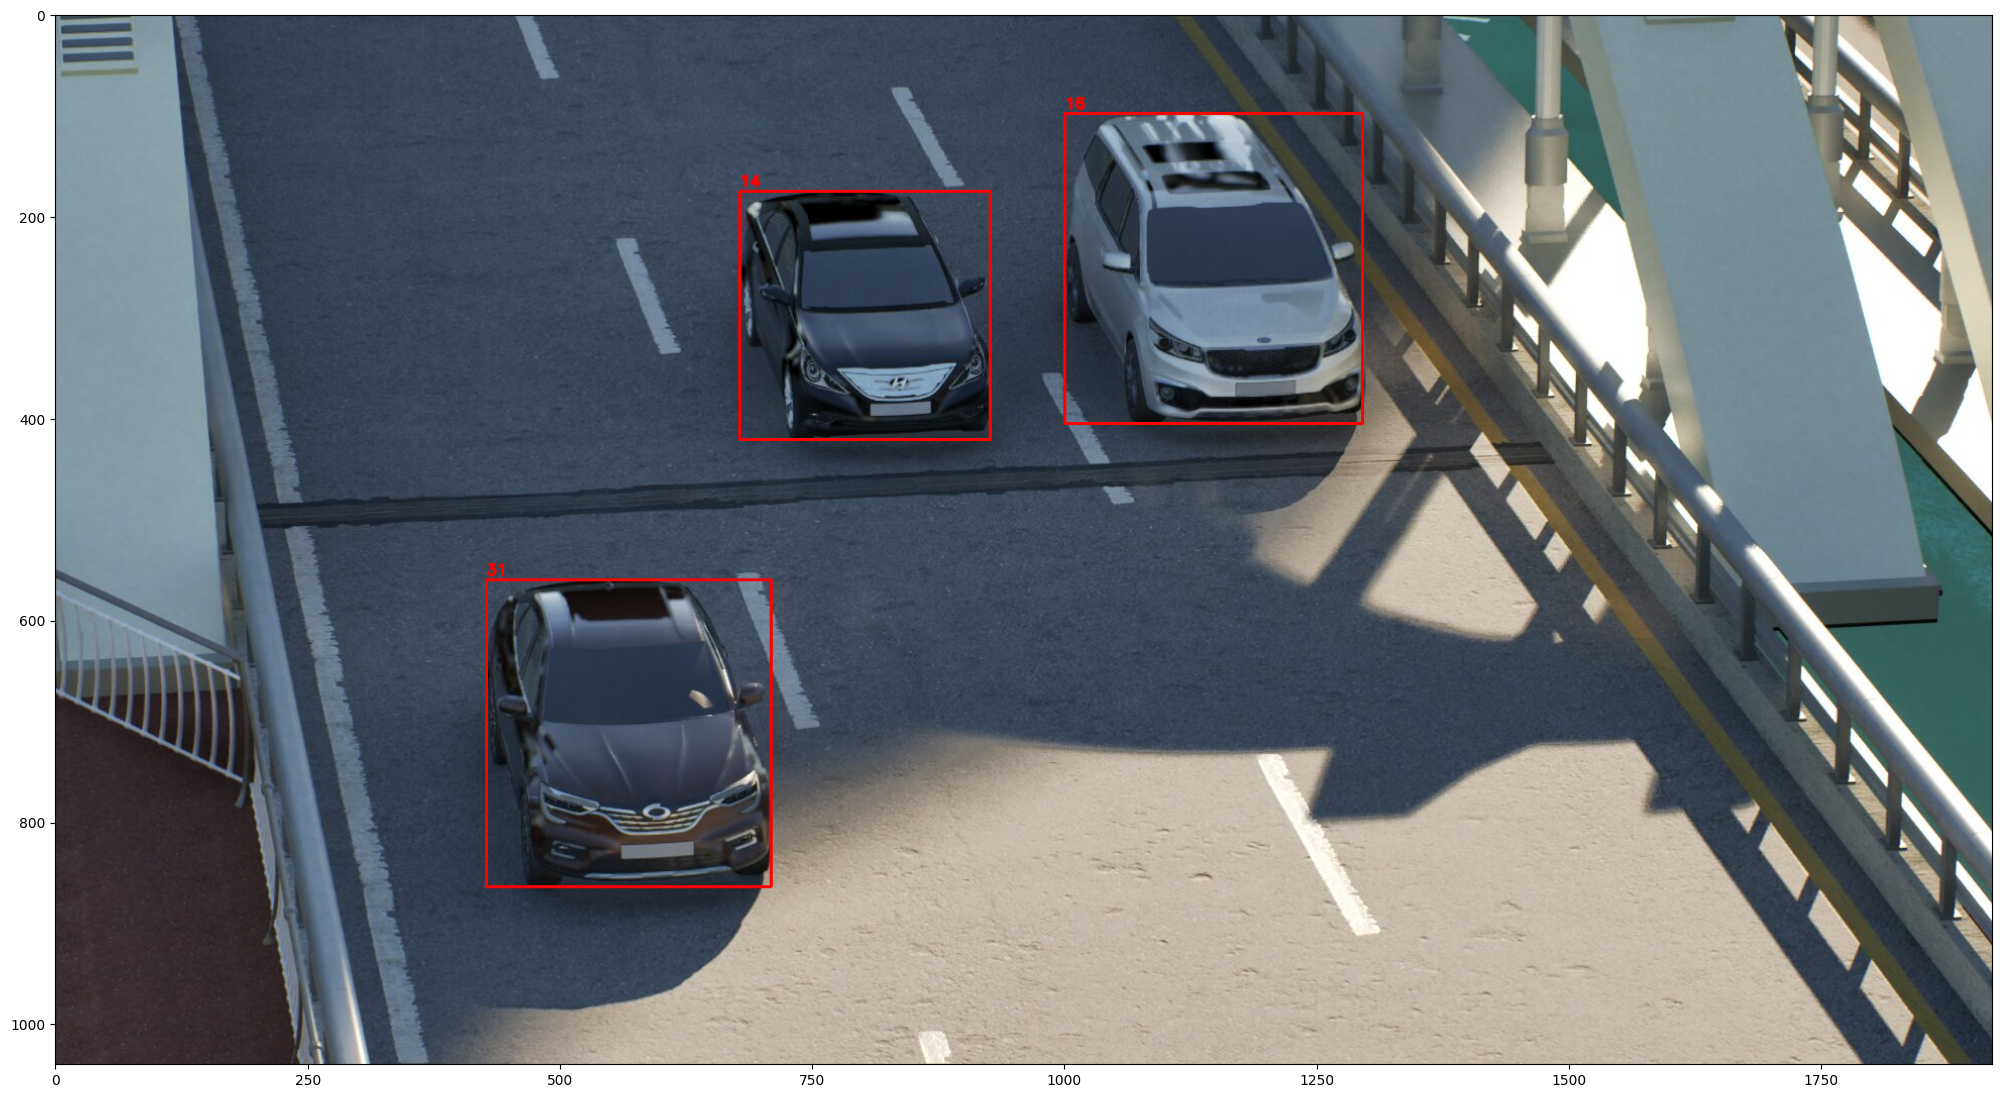

In [8]:
def draw_boxes_on_image(image_path, annotation_path):
    # 이미지 불러오기
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # txt 파일에서 Class ID와 Bounding Box 정보 읽기
    with open(annotation_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        values = list(map(float, line.strip().split(' ')))
        class_id = int(values[0])
        x_min, y_min = int(round(values[1])), int(round(values[2]))
        x_max, y_max = int(round(max(values[3], values[5], values[7]))), int(round(max(values[4], values[6], values[8])))

        # 이미지에 바운딩 박스 그리기
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        cv2.putText(image, str(class_id), (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # 이미지와 바운딩 박스 출력
    plt.figure(figsize=(25, 25))
    plt.imshow(image)
    plt.show()
    
# 파일 경로 설정
image_file = os.path.join(DATA_PATH, 'images/syn_00001.png')
annotation_file = os.path.join(DATA_PATH, 'images/syn_00001.txt')

# 함수 실행
draw_boxes_on_image(image_file, annotation_file)

## Custom Dataset

In [9]:
def collate_fn(batch):
    images, targets_boxes, targets_labels = tuple(zip(*batch))
    images = torch.stack(images, 0)
    targets = []
    
    for i in range(len(targets_boxes)):
        target = {
            "boxes": targets_boxes[i],
            "labels": targets_labels[i]
        }
        targets.append(target)

    return images, targets

In [10]:
class CustomDataset(Dataset):
    def __init__(self, root, train=True, transforms=None):
        self.root = root
        self.train = train
        self.transforms = transforms
        self.imgs = sorted(glob.glob(root+'/*.png'))
        
        if train:
            self.boxes = sorted(glob.glob(root+'/*.txt'))

    def parse_boxes(self, box_path):
        with open(box_path, 'r') as file:
            lines = file.readlines()

        boxes = []
        labels = []

        for line in lines:
            values = list(map(float, line.strip().split(' ')))
            class_id = int(values[0])
            x_min, y_min = int(round(values[1])), int(round(values[2]))
            x_max, y_max = int(round(max(values[3], values[5], values[7]))), int(round(max(values[4], values[6], values[8])))

            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(class_id)

        return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = cv2.imread(self.imgs[idx])
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img /= 255.0
        height, width = img.shape[0], img.shape[1]

        if self.train:
            box_path = self.boxes[idx]
            boxes, labels = self.parse_boxes(box_path)
            labels += 1 # Background = 0

            if self.transforms is not None:
                transformed = self.transforms(image=img, bboxes=boxes, labels=labels)
                img, boxes, labels = transformed["image"], transformed["bboxes"], transformed["labels"]

            img = torch.tensor(img, dtype=torch.float32)
            img /= 255.0
                
            return img, torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)

        else:
            if self.transforms is not None:
                transformed = self.transforms(image=img)
                img = transformed["image"]

            img = torch.tensor(img, dtype=torch.float32)
            img /= 255.0
            
            file_name = img_path.replace('\\', '/').split('/')[-1]
            return file_name, img, width, height

    def __len__(self):
        return len(self.imgs)

In [11]:
def get_train_transforms():
    return A.Compose([
        A.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
        A.ToGray(p=1),
        A.CLAHE(p=1),
        A.MotionBlur(blur_limit=3, p=0.3),
        # A.Normalize(),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_test_transforms():
    return A.Compose([
        A.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
        A.ToGray(p=1),
        A.CLAHE(p=1),
        # A.Normalize(),
        ToTensorV2(),
    ])

In [12]:
train_dataset = CustomDataset(os.path.join(DATA_PATH, 'images/'), train=True, transforms=get_train_transforms())
test_dataset = CustomDataset(os.path.join(DATA_PATH, 'test/'), train=False, transforms=get_test_transforms())

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

## Define Model

In [13]:
def build_model(num_classes=CFG['NUM_CLASS']+1):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, image_mean=CFG['MEAN'], image_std=CFG['STD'])
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

## Train & Validation

In [14]:
def train(
    model, 
    train_loader,
    optimizer, 
    scheduler, 
    device
):
    model.to(device)

    best_loss = 9999999
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for images, targets in tqdm(iter(train_loader)):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            optimizer.zero_grad()

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            losses.backward()
            optimizer.step()

            train_loss.append(losses.item())

        if scheduler is not None:
            scheduler.step()
        
        tr_loss = np.mean(train_loss)

        print(f'Epoch [{epoch}] Train loss : [{tr_loss:.5f}]\n')
        
        if best_loss > tr_loss:
            best_loss = tr_loss
            best_model = model
    
    return best_model

In [15]:
model = build_model()
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.4325, 0.4325, 0.4325], std=[0.23, 0.23, 0.23])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LR'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

infer_model = train(model, train_loader, optimizer, scheduler, device)

  0%|          | 0/811 [00:00<?, ?it/s][W MPSFallback.mm:11] Warning: The operator 'torchvision::nms' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (function operator())


## Inference & Submission

In [ ]:
def box_denormalize(x1, y1, x2, y2, width, height):
    x1 = (x1 / CFG['IMG_SIZE']) * width
    y1 = (y1 / CFG['IMG_SIZE']) * height
    x2 = (x2 / CFG['IMG_SIZE']) * width
    y2 = (y2 / CFG['IMG_SIZE']) * height
    return x1.item(), y1.item(), x2.item(), y2.item()

def inference(model, test_loader, device):
    model.eval()
    model.to(device)
    
    results = pd.read_csv('./sample_submission.csv')

    for img_files, images, img_width, img_height in tqdm(iter(test_loader)):
        images = [img.to(device) for img in images]

        with torch.no_grad():
            outputs = model(images)

        for idx, output in enumerate(outputs):
            boxes = output["boxes"].cpu().numpy()
            labels = output["labels"].cpu().numpy()
            scores = output["scores"].cpu().numpy()

            for box, label, score in zip(boxes, labels, scores):
                x1, y1, x2, y2 = box
                x1, y1, x2, y2 = box_denormalize(x1, y1, x2, y2, img_width[idx], img_height[idx])
                results.loc[len(results)] = {
                    "file_name": img_files[idx],
                    "class_id": label-1,
                    "confidence": score,
                    "point1_x": x1, "point1_y": y1,
                    "point2_x": x2, "point2_y": y1,
                    "point3_x": x2, "point3_y": y2,
                    "point4_x": x1, "point4_y": y2
                }

    # 결과를 CSV 파일로 저장
    results.to_csv(f'{SUBMIT_NAME}.csv', index=False)
    print('Done.')

In [ ]:
inference(infer_model, test_loader, device)